In [1]:
# @title Build madrona and install madrona mjx
# install additional missing packages
!sudo apt install -y libx11-dev libxrandr-dev libxinerama-dev libxcursor-dev libxi-dev mesa-common-dev
#!sudo apt install -y nvidia-cuda-toolkit

# install jax with cuda enabled
!pip install -U "jax[cuda12_local]<0.6.0"

# get madrona mjx and its subpackages
!mkdir modules
!git clone https://github.com/shacklettbp/madrona_mjx.git modules/madrona_mjx
!git -C modules/madrona_mjx submodule update --init --recursive

# build madrona mjx
!mkdir modules/madrona_mjx/build
!cd modules/madrona_mjx/build && cmake -DLOAD_VULKAN=OFF .. && make -j 8

# install madrona mjx
!pip install -e modules/madrona_mjx

# install other libraries
!pip install mujoco==3.3.2
!pip install mujoco_mjx==3.3.2
!pip install brax
!pip install playground
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libx11-dev is already the newest version (2:1.7.5-1ubuntu0.3).
libx11-dev set to manually installed.
The following additional packages will be installed:
  libdrm-dev libgl-dev libglx-dev libpciaccess-dev libxfixes-dev
The following NEW packages will be installed:
  libdrm-dev libgl-dev libglx-dev libpciaccess-dev libxcursor-dev
  libxfixes-dev libxi-dev libxinerama-dev libxrandr-dev mesa-common-dev
0 upgraded, 10 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,906 kB of archives.
After this operation, 6,893 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpciaccess-dev amd64 0.16-3 [21.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdrm-dev amd64 2.4.113-2~ubuntu0.22.04.1 [292 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:4 http://archive.ubuntu.

In [1]:
# @title Imports and definitions

import os
# On your second reading, load the compiled rendering backend to save time!
# os.environ["MADRONA_MWGPU_KERNEL_CACHE"] = "<YOUR_PATH>/madrona_mjx/build/cache"
# Ensure that Madrona gets the chance to pre-allocate memory before Jax
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# More legible printing from numpy.
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Typing
from collections.abc import Callable

# Utility
from functools import partial

# Visualisation
import mediapy as media
import matplotlib.pyplot as plt

# Simulation
import mujoco
from mujoco import mjx

# Math
import jax
import jax.numpy as jnp

# Brax
# from brax.io import mjcf
# from brax.envs.base import Env, PipelineEnv, State, Wrapper

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


In [ ]:
#   <visual>
#     <headlight diffuse="0.6 0.6 0.6" ambient="0.3 0.3 0.3" specular="0 0 0"/>
#     <rgba haze="0.15 0.25 0.35 1"/>
#     <global azimuth="120" elevation="-20"/>
#   </visualdirectional="true">
# <keyframe>
#     <key name="home" qpos="1 0 0 0"/>
#   </keyframe>

SyntaxError: invalid syntax (<ipython-input-2-e664dff17f3e>, line 1)

""

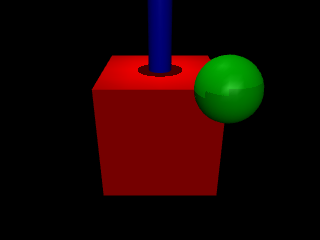

In [2]:
# @title Model definition
xml = """
<mujoco>
  <worldbody>
    <camera name="frontal" pos="1 0 .5" xyaxes="0 1 0 -0.5 0 1"/>
    <light name="top" pos="0 0 1" diffuse="0.5 0.5 0.5" ambient="0.2 0.2 0.2" specular="0.3 0.3 0.3"/>
    <body name="thing">
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
      <body name="lever">
        <joint name="arm" type="ball"/>
        <geom name="blue_capsule" type="capsule" size="0.04" fromto="0 0 .2 0 0 0.6" rgba="0 0 1 1"/>
      </body>
    </body>
  </worldbody>
  <actuator>
    <motor name="my_motor" joint="arm"/>
  </actuator>
  <keyframe>
    <key name="home" qpos="1 0 0 0"/>
  </keyframe>
</mujoco>
"""

# Make the model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data, camera="frontal")
    media.show_image(renderer.render())

In [3]:
# @title Define a very basic vision environment
from mujoco_playground import (
    MjxEnv,
    State,
    init as pipeline_init,
    step as pipeline_step,
)
from ml_collections.config_dict import ConfigDict

sim_dt = 0.002 # @param {"type":"number"}
ctrl_dt = 0.04 # @param {"type":"number"}
num_envs = 32 # @param {"type": "integer"}
use_vision = True # @param {"type":"boolean"}
gpu_id = 0 # @param {"type": "integer"}
render_batch_size = num_envs
render_width = 64 # @param {"type": "integer"}
render_height = 64 # @param {"type": "integer"}
use_rasterizer = False # @param {"type": "boolean"}
enabled_geom_groups = [0, 1, 2] # @param
enabled_cameras = [0] # @param

class SimpleVisionEnv(MjxEnv):
    def __init__(self, mj_model: mujoco.MjModel):
        super().__init__(ConfigDict({"sim_dt": sim_dt, "ctrl_dt": ctrl_dt}))

        self._xml_path = None
        self._mj_model = mj_model
        self._mj_model.opt.timestep = self.sim_dt
        self._mjx_model = mjx.put_model(self._mj_model)
        self._init_q = self._mj_model.keyframe("home").qpos

        if use_vision:
            from madrona_mjx import BatchRenderer

            self.renderer = BatchRenderer(
                m=self._mjx_model,
                gpu_id=gpu_id,
                num_worlds=render_batch_size,
                batch_render_view_width=render_width,
                batch_render_view_height=render_height,
                enabled_geom_groups=np.asarray(enabled_geom_groups),
                enabled_cameras=np.asarray(enabled_cameras),
                add_cam_debug_geo=False,
                use_rasterizer=use_rasterizer,
                viz_gpu_hdls=None,
            )
            self._use_vision = True

        else:
            self._use_vision = False

    def reset(self, rng):
        # force a noop with rng for correct broadcasting
        init_q = self._init_q + jax.random.uniform(rng, shape=self._init_q.shape, minval=0.0, maxval=0.0)

        pipeline_state = pipeline_init(self.mjx_model, init_q)

        state_info = {"rng": rng}

        obs = self._init_obs(pipeline_state, state_info)

        reward, done = jnp.zeros(2)

        metrics = {}

        state = State(pipeline_state, obs, reward, done, metrics, state_info)
        return state

    def step(self, state, action):

        obs = self._get_obs(state.data, state.info)

        state = state.tree_replace({"obs": obs})
        return state

    def _init_obs(self, pipeline_state, state_info):
        if self._use_vision:
            render_token, rgb, depth = self.renderer.init(pipeline_state, self._mjx_model)
            state_info["render_token"] = render_token
            rgb_tensor = jnp.asarray(rgb[..., :3], dtype=jnp.float32) / 255.0
            obs = {"rgb": rgb_tensor, "depth": depth}
        else:
            obs = {}
        return obs

    def _get_obs(self, pipeline_state, state_info):
        if self._use_vision:
            _, rgb, depth = self.renderer.render(state_info["render_token"], pipeline_state)
            rgb_tensor = jnp.asarray(rgb[..., :3], dtype=jnp.float32) / 255.0
            obs = {"rgb": rgb_tensor, "depth": depth}
        else:
            obs = {}
        return obs

    @property
    def xml_path(self):
        return self._xml_path

    @property
    def action_size(self):
        return None

    @property
    def mj_model(self):
        return self._mj_model

    @property
    def mjx_model(self):
        return self._mjx_model

In [4]:
env = SimpleVisionEnv(model)

In [5]:
# @title Wrap the simple environment
from mujoco_playground import wrapper
wrapped_env = wrapper.wrap_for_brax_training(
    env=env,
    vision=True,
    num_vision_envs=num_envs,
    randomization_fn=None,
)

jit_reset = jax.jit(wrapped_env.reset)
#jit_step = jax.jit(wrapped_env.step)

In [6]:
state = jit_reset(jax.random.split(jax.random.PRNGKey(0), num_envs))
rgb_tensor = state.obs['rgb']

Inferred batch not found, overriding manually
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually


In [7]:
def tile(img, d):
    assert img.shape[0] == d*d
    img = img.reshape((d,d)+img.shape[1:])
    return np.concat(np.concat(img, axis=2), axis=2)

image = tile(rgb_tensor[:16], 4)
image.shape

XlaRuntimeError: INTERNAL: There was an error before calling cuModuleGetFunction (1): cudaErrorInvalidValue : invalid argument

""

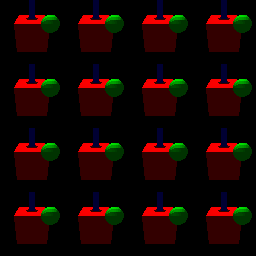

In [11]:
media.show_image(image[0], width=512)